# Exploratory Data Analysis

### Fundamental research question:
**How can I best encode the state of a basketball team?**

what information is available?
- past performance: shooting percentages, etc.
- recent performance: momentum is huge in basketball
- who they've played (Stength of Schedule)
- player attributes: height, yrs exp

what information is unavailable?
- injuries
- coaching staff information
- gameplan specifics
- ther player physical attributes (ex. vertical)
- player moods, goals, personal life details that can affect the game



what features to I want to test for predictivity?
- win percentage, SOS, 2FG%, 3FG%, 3PA%, FT%, FTM/possession, points/possession, blocks, steals, TO/possession and allowed for all these stats
- momentum: how have you performed lately?
- home/away/neutral
- conference
- experience and size (pull off of ESPN or something)
- pace


### Procedure
1. calculate each stat for each team in each game in each season
    - decide how to calculate momentum, strength-of-schedule/opponent, experience and size
2. create data.csv with each feature for each of 2 teams, home & away, with label for that game
3. test feature importance
4. test many models
    - XGBoost
    - MLP
    - model data as sequence of games for transformer?




In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
regular_season = pd.read_csv('data_2025/MRegularSeasonDetailedResults.csv')
tourney = pd.read_csv('data_2025/MNCAATourneyDetailedResults.csv')

In [ ]:
all_season = pd.concat([regular_season,tourney], axis=0)

# Pace: total possessions = fga - orb + to + (0.475 * fta)
# add pace to regular_season
all_season["WNum_possessions"] = all_season["WFGA"] - all_season["WOR"] + all_season["WTO"] + (0.475 * all_season["WFTA"])
all_season["LNum_possessions"] = all_season["LFGA"] - all_season["LOR"] + all_season["LTO"] + (0.475 * all_season["LFTA"])

all_season = all_season.drop(columns=["WLoc", "NumOT"]) # drop location column because all tourney games are neutral

# Create team0 and team1 IDs and a label (1 if team0 is the original winner)
all_season["team0_ID"] = np.where(np.random.rand(len(all_season)) > 0.5, all_season["WTeamID"], all_season["LTeamID"])
all_season["team1_ID"] = np.where(all_season["team0_ID"] == all_season["WTeamID"], all_season["LTeamID"], all_season["WTeamID"])
all_season["label"] = np.where(all_season["team0_ID"] == all_season["WTeamID"], 1, 0)


# List of stat names (without the team identifier) to update:
stat_names = ["FGM", "FGA", "FGM3", "FGA3", "FTA", "FTM", "OR", "DR", "Ast", "TO", "Stl", "Blk", "PF", "Num_possessions"]

# For each stat, assign team0_stat and team1_stat based on the label:
for stat in stat_names:
    all_season["team0_" + stat] = np.where(all_season["label"] == 1, all_season["W" + stat], all_season["L" + stat])
    all_season["team1_" + stat] = np.where(all_season["label"] == 1, all_season["L" + stat], all_season["W" + stat])
    
# drop cols that are no longer needed
cols_to_drop = [col for col in all_season.columns if col.startswith("W") or col.startswith("L")]
all_season.drop(columns=cols_to_drop, inplace=True)

## Construct Train/Test Set

only consider games after day 50 so that the priors are less noisy

In [ ]:
print("cutting out", len(all_season[all_season["DayNum"] <= 50]), "games in the regular season")

all_season_cut = all_season[all_season["DayNum"] > 50]
# print lenth of regular_season when daynum is > 66
print("leaving", len(all_season_cut), "games in the regular season set")

In [ ]:
# given a team name list of all basketball games of a team from a season up to a certain date, return the sum 
# of all the stats for that team, dropping their opponent's stats

def get_team_stats(team_ID, games):
    stat_list = []
    for index, row in games.iterrows():
        if row["team0_ID"] == team_ID:
            s = row[["team0_FGA", "team0_FGM", "team0_FGA3", "team0_FGM3", 
                     "team0_FTA", "team0_FTM", "team0_OR", "team0_DR", 
                     "team0_Ast", "team0_TO", "team0_Stl", "team0_Blk", 
                     "team0_PF", "team0_Num_possessions", "team1_FGA", "team1_FGM", "team1_FGA3", "team1_FGM3", "team1_Num_possessions"]]
            # rename the stats to a common name
            s.index = [col.replace("team0_", "") for col in s.index]
            s.index = [col.replace("team1_", "o") for col in s.index]
            stat_list.append(s)
        elif row["team1_ID"] == team_ID:
            s = row[["team1_FGA", "team1_FGM", "team1_FGA3", "team1_FGM3", 
                     "team1_FTA", "team1_FTM", "team1_OR", "team1_DR", 
                     "team1_Ast", "team1_TO", "team1_Stl", "team1_Blk", 
                     "team1_PF", "team1_Num_possessions", "team0_FGA", "team0_FGM", "team0_FGA3", "team0_FGM3", "team0_Num_possessions"]]
            s.index = [col.replace("team1_", "") for col in s.index]
            s.index = [col.replace("team0_", "o") for col in s.index]
            stat_list.append(s)
    if stat_list:
        stats_df = pd.DataFrame(stat_list).sum()
        # Create a dictionary to store the calculated stats
        calculated_stats = {}
        
        # Perform calculations, handling potential division by zero
        calculated_stats["2PtFg%"] = (stats_df["FGM"] - stats_df["FGM3"]) / (stats_df["FGA"] - stats_df["FGA3"]) if (stats_df["FGA"] - stats_df["FGA3"]) != 0 else 0
        calculated_stats["3PtA%"] = stats_df["FGA3"] / stats_df["FGA"] if stats_df["FGA"] != 0 else 0
        calculated_stats["3PtFg%"] = stats_df["FGM3"] / stats_df["FGA3"] if stats_df["FGA3"] != 0 else 0
        calculated_stats["FTA/poss"] = stats_df["FTA"] / stats_df["Num_possessions"] if stats_df["Num_possessions"] != 0 else 0
        calculated_stats["FT%"] = stats_df["FTM"] / stats_df["FTA"] if stats_df["FTA"] != 0 else 0
        calculated_stats["OR%"] = stats_df["OR"] / (stats_df["FGA"] - stats_df["FGM"]) if (stats_df["FGA"] - stats_df["FGM"]) != 0 else 0
        calculated_stats["DR%"] = stats_df["DR"] / (stats_df["oFGA"] - stats_df["oFGM"]) if (stats_df["oFGA"] - stats_df["oFGM"]) != 0 else 0
        calculated_stats["Ast%"] = stats_df["Ast"] / stats_df["FGM"] if stats_df["FGM"] != 0 else 0
        calculated_stats["TO%"] = stats_df["TO"] / stats_df["Num_possessions"] if stats_df["Num_possessions"] != 0 else 0
        calculated_stats["Stl%"] = stats_df["Stl"] / stats_df["oNum_possessions"] if stats_df["oNum_possessions"] != 0 else 0
        calculated_stats["Blk%"] = stats_df["Blk"] / stats_df["oFGA"] if stats_df["oFGA"] != 0 else 0
        calculated_stats["PF%"] = stats_df["PF"] / (stats_df["Num_possessions"] + stats_df["oNum_possessions"]) if (stats_df["Num_possessions"] + stats_df["oNum_possessions"]) != 0 else 0
        calculated_stats["poss/gm"] = stats_df["Num_possessions"] / len(stat_list) if len(stat_list) != 0 else 0
        calculated_stats["o2PtFg%"] = (stats_df["oFGM"] - stats_df["oFGM3"]) / (stats_df["oFGA"] - stats_df["oFGA3"]) if (stats_df["oFGA"] - stats_df["oFGA3"]) != 0 else 0
        calculated_stats["o3PtFg%"] = stats_df["oFGM3"] / stats_df["oFGA3"] if stats_df["oFGA3"] != 0 else 0
        
        # Create DataFrame from the dictionary
        df = pd.DataFrame(calculated_stats, index=[0])

        return df
    else:
        print("error?")
        return pd.DataFrame()

In [ ]:
columns = ["2PtFg%", "3PtA%", "3PtFg%", "FTA/poss", "FT%", "OR%", "DR%", "Ast%", "TO%", "Stl%", "Blk%", "PF%", "poss/gm", "o2PtFg%", "o3PtFg%", "ID"]
columns = ["team0_" + col for col in columns]
columns = columns + ["team1_" + col[6:] for col in columns] + ["winner"]

df = pd.DataFrame(columns=columns)

first_season = min(all_season["Season"])
last_season = max(all_season["Season"])

err_counter = 0

for season in range(first_season, last_season+1):
    print("Season: " + str(season))
    this_season = all_season[all_season["Season"] == season]
    this_season_cut = all_season_cut[all_season_cut["Season"] == season]

    # loop for each game in the season
    for index, game in this_season_cut.iterrows():
        day = game["DayNum"]
        team0_ID = game["team0_ID"]
        team1_ID = game["team1_ID"]
        this_season_before_day = this_season[this_season["DayNum"] < day]
        team0_prev_games = this_season_before_day[(this_season_before_day["team0_ID"] == team0_ID) | (this_season_before_day["team1_ID"] == team0_ID)]
        team1_prev_games = this_season_before_day[(this_season_before_day["team0_ID"] == team1_ID) | (this_season_before_day["team1_ID"] == team1_ID)]
        team0_stats = get_team_stats(team0_ID, team0_prev_games)
        team1_stats = get_team_stats(team1_ID, team1_prev_games)
        if team0_stats.empty or team1_stats.empty:
            err_counter += 1
            continue

        # add team_ to colnames
        new_columns = {col: "team0_" + col for col in team0_stats.columns}
        team0_stats = team0_stats.rename(columns=new_columns)
        team0_stats["team0_ID"] = team0_ID
        new_columns = {col: "team1_" + col for col in team1_stats.columns}
        team1_stats = team1_stats.rename(columns=new_columns)
        team1_stats["team1_ID"] = team1_ID
        #combine both teams into one row
        g = pd.concat([team0_stats, team1_stats], axis=1)
        g["winner"] = game["label"]
        g["day"] = day
        df = pd.concat([df, g], axis=0)

df.to_csv("data_2025/clean/data1.csv", index=False)

In [ ]:
df = pd.read_csv("data_2025/clean/data.csv")

# Todo: use team IDs to find team heights, exp


# Todo: encode strength of schedule


# Todo: use day and teamIDs to encode momentum?



# the test set is all games after day 134
X_train_df = df[df["day"] < 134]
y_train_df = X_train_df["winner"]
X_train_df = X_train_df.drop(columns=["winner", "day", "team0_ID", "team1_ID"])

X_test_df_pre = df[df["day"] >= 134]
y_test = X_test_df_pre["winner"]
X_test_df = X_test_df_pre.drop(columns=["winner", "day", "team0_ID", "team1_ID"])

X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=.1, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test_df)

## Feature Importance

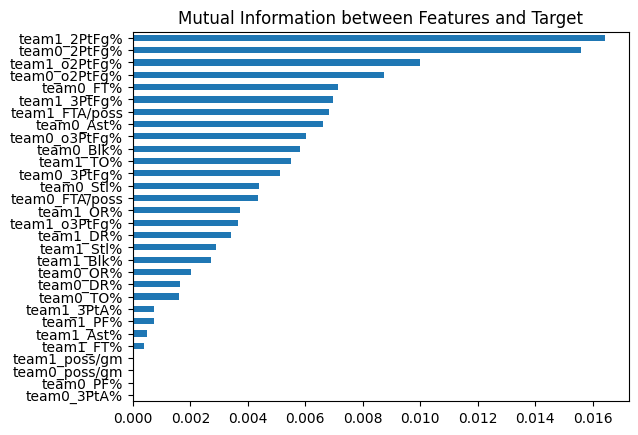

In [273]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression


mi = mutual_info_regression(X_train_df, y_train_df)
mi_series = pd.Series(mi, index=X_train_df.columns)

# Plot
mi_series.sort_values().plot(kind="barh", title="Mutual Information between Features and Target")
plt.show()

## Models

In [312]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

def eval(y_pred, y_test, y_probs=None):
    # accuracy
    acc = accuracy_score(y_test, y_pred)
    print("accuracy:", acc)

    if y_probs is not None:
        plot_roc_auc(y_probs, y_test)
    
def plot_roc_auc(y_probs, y_test):
    # Compute ROC curve
    # Assuming y_test and y_probs are already defined
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)

    # Calculate Youden's J statistic and find the threshold with maximum value
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"Optimal threshold (Youden's J): {optimal_threshold:.4f}")
    
    roc_auc = roc_auc_score(y_test, y_probs)
    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

accuracy: 0.6570342205323194
Optimal threshold (Youden's J): 0.5032


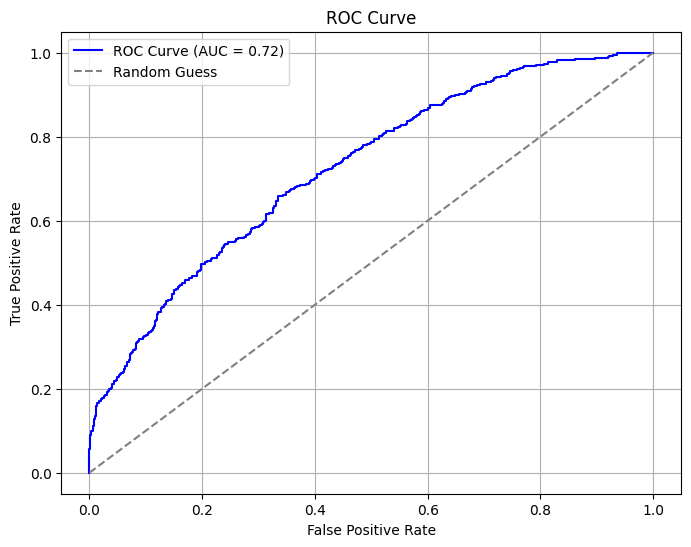

In [313]:
# start with linear model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='elasticnet', l1_ratio=.5, C=.1, solver='saga').fit(X_train, y_train)
y_probs = lr.predict_proba(X_test)[:, 1]  # Get probability for the positive class
y_pred = lr.predict(X_test)

eval(y_pred, y_test, y_probs)

accuracy: 0.6418250950570342
Optimal threshold (Youden's J): 0.5755


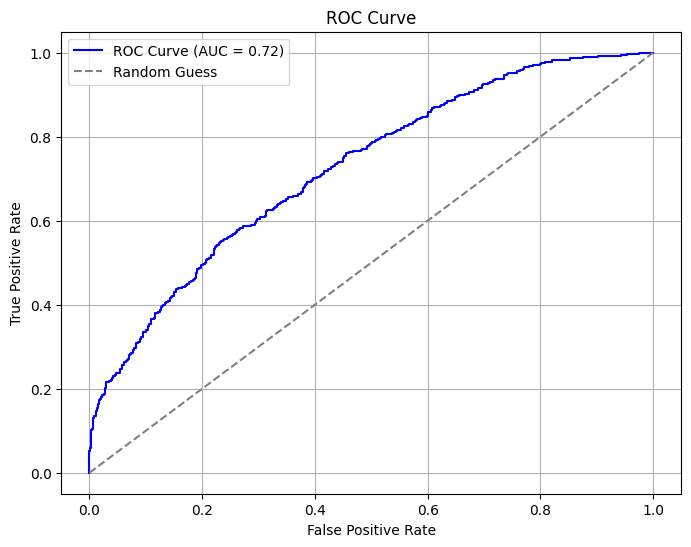

In [330]:
from sklearn.neural_network import MLPClassifier

MLP = MLPClassifier(hidden_layer_sizes=(500, 300, 100, 25, 5), solver="adam", alpha=.01, early_stopping=True).fit(X_train, y_train)
y_probs = MLP.predict_proba(X_test)[:, 1]  # Get probability for the positive class
y_pred = MLP.predict(X_test)
eval(y_pred, y_test, y_probs)

accuracy: 0.6631178707224334
Optimal threshold (Youden's J): 0.4762


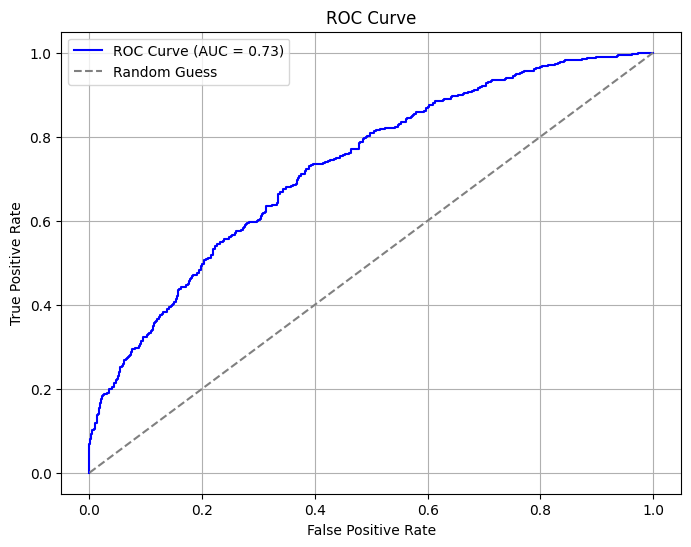

In [333]:
MLP_small = MLPClassifier(hidden_layer_sizes=(25, 20, 5), solver="adam", alpha=.1, early_stopping=True).fit(X_train, y_train)
y_pred = MLP_small.predict(X_test)
y_probs = MLP_small.predict_proba(X_test)[:, 1]
eval(y_pred, y_test, y_probs)

accuracy: 0.6456273764258555


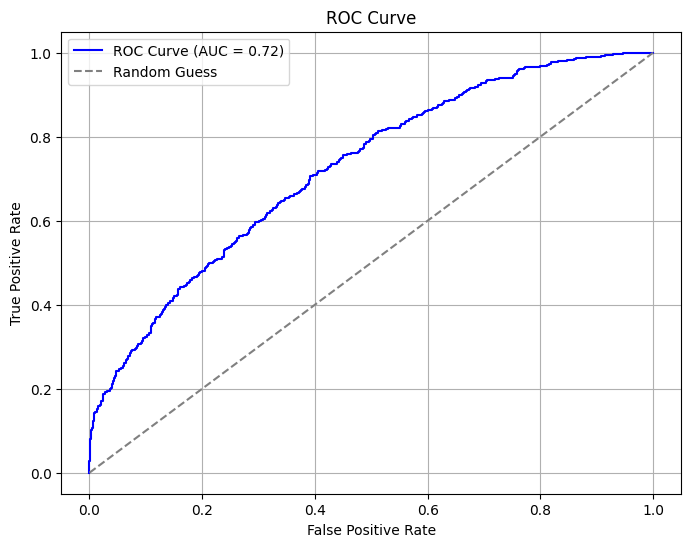

In [309]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert to DMatrix (XGBoost's optimized data structure)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 4,
    "learning_rate": 0.1,
    "n_estimators": 100
}

# Train the model
model = xgb.train(params, dtrain, num_boost_round=100)

# Make predictions
y_prob = model.predict(dtest)
y_pred = (y_prob > 0.5).astype(int)

eval(y_pred, y_test, y_probs)

## Eye Test

model sanity check - how does the model perform in the 2023 bracket? Who is it picking? How confident is it?

In [335]:
def visual_test(model):
        
    # select games from 2024 tourney
    tourney_2023 = X_test_df_pre[-63:]

    # extract team ids and labels, delete days
    team0_ids = list(tourney_2023["team0_ID"])
    team1_ids = list(tourney_2023["team1_ID"])
    y_tourney_2023 = list(tourney_2023["winner"])
    tourney_2023 = tourney_2023.drop(columns=["team0_ID", "team1_ID", "winner", "day"])

    tourney_2023 = scaler.transform(tourney_2023)

    # map team0_teamID and team1_teamID to team names via data_2025/MTeams.csv
    teams = pd.read_csv("data_2025/MTeams.csv")
    team_id_to_name = dict(zip(teams["TeamID"], teams["TeamName"]))

    # Predict probabilities for the tournament games
    predicted_probs = model.predict_proba(tourney_2023)[:, 1]
    y_pred = model.predict(tourney_2023)
    # Iterate through each game
    for i in range(len(tourney_2023)):
        # Extract team IDs (assuming they are in columns 'team0_ID' and 'team1_ID')
        team0_id = int(team0_ids[i])
        team1_id = int(team1_ids[i])
        
        # Get team names
        team0_name = team_id_to_name.get(team0_id, "Unknown Team")
        team1_name = team_id_to_name.get(team1_id, "Unknown Team")
        
        # Get predicted probability (probability that team0 wins)
        predicted_prob = predicted_probs[i]
        prediction = y_pred[i]

        # Get actual winner (assuming 'label' column indicates the winner: 1 if team0 won, 0 if team1 won)
        actual_winner = y_tourney_2023[i] #int(y_tourney_2023.iloc[i])
        
        # Print the information
        print(f"Game {i+1}:")
        print(f"  {team0_name}")
        print(f"  {team1_name}")
        predicted_winner = team0_name if prediction == 1 else team1_name
        if predicted_prob < .5:
            predicted_prob = 1 - predicted_prob
        print(f"  Prediction: {predicted_winner}: {predicted_prob:.3f}")
        print(f"  Actual winner: {team0_name if actual_winner == 1 else team1_name}")
        print("-" * 30)

In [336]:
visual_test(MLP)

Game 1:
  TAM C. Christi
  Alabama
  Prediction: Alabama: 0.721
  Actual winner: Alabama
------------------------------
Game 2:
  Arkansas
  Illinois
  Prediction: Arkansas: 0.505
  Actual winner: Arkansas
------------------------------
Game 3:
  Iowa
  Auburn
  Prediction: Iowa: 0.563
  Actual winner: Auburn
------------------------------
Game 4:
  Oral Roberts
  Duke
  Prediction: Oral Roberts: 0.569
  Actual winner: Duke
------------------------------
Game 5:
  Furman
  Virginia
  Prediction: Furman: 0.548
  Actual winner: Furman
------------------------------
Game 6:
  Houston
  N Kentucky
  Prediction: Houston: 0.873
  Actual winner: Houston
------------------------------
Game 7:
  Kansas
  Howard
  Prediction: Kansas: 0.785
  Actual winner: Kansas
------------------------------
Game 8:
  West Virginia
  Maryland
  Prediction: Maryland: 0.550
  Actual winner: Maryland
------------------------------
Game 9:
  Utah St
  Missouri
  Prediction: Utah St: 0.558
  Actual winner: Missouri